In [34]:
import pandas as pd
from google.colab import files
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, accuracy_score


In [2]:
upload = files.upload()

Saving credit_risk_dataset.csv to credit_risk_dataset.csv


In [3]:
data = pd.read_csv("credit_risk_dataset.csv")

In [4]:
data.head()

,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
0,22,59000,RENT,123.0,PERSONAL,D,35000,16.02,1,0.59,Y,3
1,21,9600,OWN,5.0,EDUCATION,B,1000,11.14,0,0.10,N,2
2,25,9600,MORTGAGE,1.0,MEDICAL,C,5500,12.87,1,0.57,N,3
3,23,65500,RENT,4.0,MEDICAL,C,35000,15.23,1,0.53,N,2
4,24,54400,RENT,8.0,MEDICAL,C,35000,14.27,1,0.55,Y,4


In [11]:
missing_values = data.isnull().any(axis=1)
print('Rows with missing values:')
print(missing_values[missing_values==True])

Rows with missing values:
Series([], dtype: bool)


In [9]:
data.dropna(axis=0, inplace=True)

In [13]:
duplicate_rows = data[data.duplicated()]
print('Duplicate rows:')
print(duplicate_rows)

Duplicate rows:
Empty DataFrame
Columns: [person_age, person_income, person_home_ownership, person_emp_length, loan_intent, loan_grade, loan_amnt, loan_int_rate, loan_status, loan_percent_income, cb_person_default_on_file, cb_person_cred_hist_length]
Index: []


In [15]:
data.drop_duplicates(inplace=True)

In [22]:

correlation_df = data[["loan_percent_income","loan_status"]]

In [23]:
correlation = correlation_df["loan_percent_income"].corr(correlation_df["loan_status"])
print(f"Correlation Between Debt to Income Ratio and Default Rate: {correlation}")

Correlation Between Debt to Income Ratio and Default Rate: 0.38000025291817946


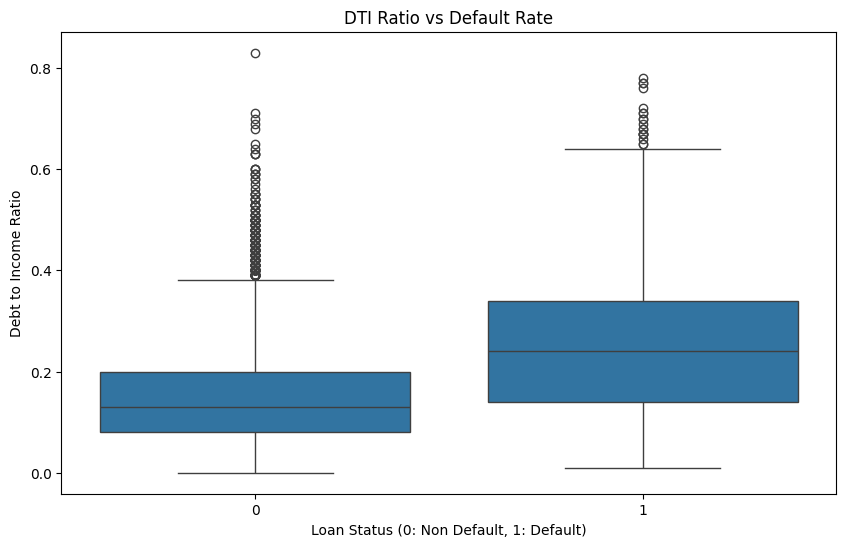

In [24]:
plt.figure(figsize=(10,6))
sns.boxplot(x="loan_status", y="loan_percent_income", data=data)
plt.title("DTI Ratio vs Default Rate")
plt.xlabel("Loan Status (0: Non Default, 1: Default)")
plt.ylabel("Debt to Income Ratio")
plt.show()

Ranking of Loan Intents by Default Count:
         Loan Intent  Default Count  Average Loan Amount
3            MEDICAL           1418         11373.748237
0  DEBTCONSOLIDATION           1294         11316.750386
1          EDUCATION            967         11160.082730
4           PERSONAL            961         10708.896982
2    HOMEIMPROVEMENT            820          9966.067073
5            VENTURE            728         11304.910714

Ranking of Loan Intents by Average Loan Amount:
         Loan Intent  Default Count  Average Loan Amount
3            MEDICAL           1418         11373.748237
0  DEBTCONSOLIDATION           1294         11316.750386
5            VENTURE            728         11304.910714
1          EDUCATION            967         11160.082730
4           PERSONAL            961         10708.896982
2    HOMEIMPROVEMENT            820          9966.067073


/tmp/ipython-input-980643570.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Default Count", y="Loan Intent", data=loan_intent_default_summary, palette="viridis", ax=ax1)


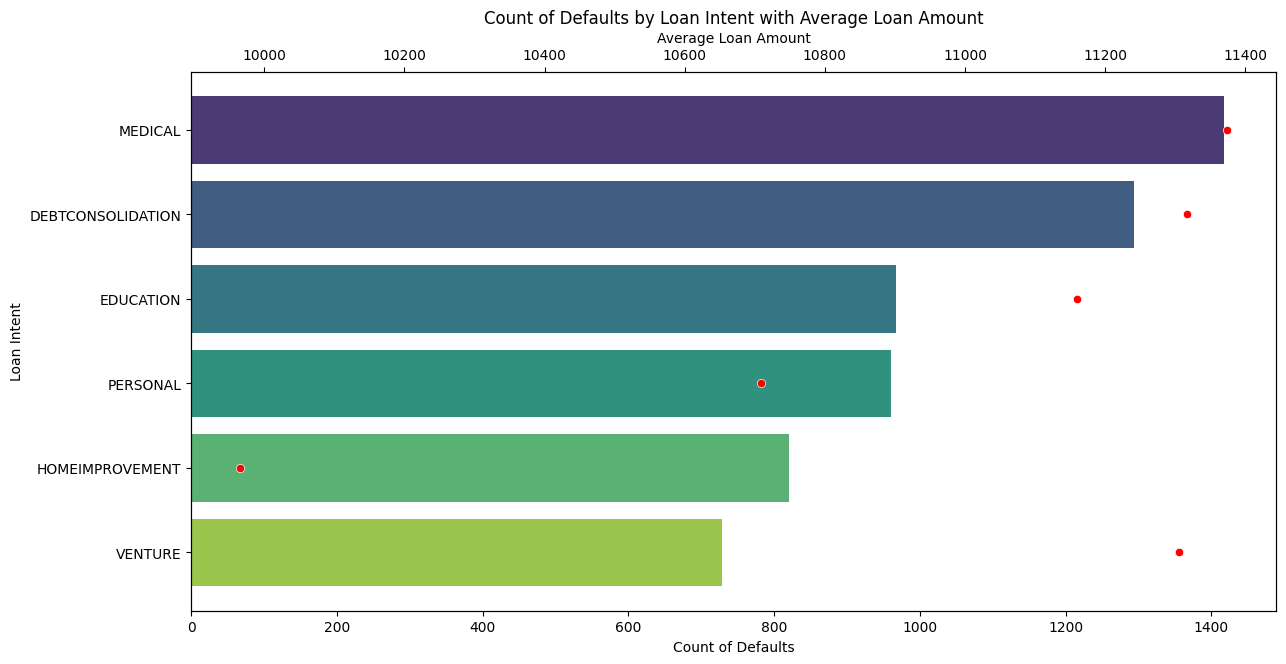

In [25]:
default_cases = data[data["loan_status"]==1]
loan_intent_default_count = default_cases.groupby("loan_intent")["loan_status"].count().reset_index()
loan_intent_default_count.columns = ["Loan Intent", "Default Count"]
loan_intent_avg_loan_amount = default_cases.groupby("loan_intent")["loan_amnt"].mean().reset_index()
loan_intent_avg_loan_amount.columns = ["Loan Intent", "Average Loan Amount"]
loan_intent_default_summary = pd.merge(loan_intent_default_count, loan_intent_avg_loan_amount, on="Loan Intent")
loan_intent_default_summary = loan_intent_default_summary.sort_values(by='Default Count', ascending=False)
defaultcount = loan_intent_default_summary.sort_values(by="Default Count", ascending=False)
print("Ranking of Loan Intents by Default Count:")
print(defaultcount)
avgloanamount = loan_intent_default_summary.sort_values(by="Average Loan Amount", ascending=False)
print("\nRanking of Loan Intents by Average Loan Amount:")
print(avgloanamount)
fig, ax1 = plt.subplots(figsize=(14,7))
sns.barplot(x="Default Count", y="Loan Intent", data=loan_intent_default_summary, palette="viridis", ax=ax1)
ax1.set_title("Count of Defaults by Loan Intent with Average Loan Amount")
ax1.set_xlabel("Count of Defaults")
ax1.set_ylabel("Loan Intent")
ax2 = ax1.twiny()
sns.scatterplot(x="Average Loan Amount", y="Loan Intent", data=loan_intent_default_summary, color="red", ax=ax2)
ax2.set_xlabel("Average Loan Amount")
plt.show()

In [26]:
pip install scikit-learn

In [30]:
X = data[["person_age", "person_income", "person_emp_length", "loan_int_rate", "person_home_ownership", "loan_intent","cb_person_default_on_file"]]
y = data["loan_status"]
numeric_features = ["person_age","person_income","person_emp_length","loan_int_rate"]
categorical_features = ["person_home_ownership","loan_intent","cb_person_default_on_file"]
numeric_transformer = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='median')),
    ('scaler',StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='most_frequent')),
    ('onehot',OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(
    transformers= [
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)
X_processed = preprocessor.fit_transform(X)
categorical_columns = preprocessor.transformers_[1][1]['onehot'].get_feature_names_out(categorical_features)
all_columns = numeric_features + list(categorical_columns)

X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)
logistic_classifier = LogisticRegression(random_state=42)
logistic_classifier.fit(X_train,y_train)
y_pred = logistic_classifier.predict(X_test)
print("Accuracy:", accuracy_score(y_test,y_pred))
print("\nClassification Report:")
print(classification_report(y_test,y_pred))
categories = {
    "person_home_ownership": ['RENT', 'OWN', 'MORTGAGE', 'OTHER'],
    "loan_intent": ['PERSONAL', 'EDUCATION', 'MEDICAL', 'VENTURE', 'HOMEIMPROVEMENT',
       'DEBTCONSOLIDATION'],
    "cb_person_default_on_file": ['Y', 'N']
}

def predict_loan_default():
  print("\nEnter applicant details for credit risk assessment:")
  age = float(input("Applicant's age:"))
  income = float(input("Applicant's income:"))
  emp_length = float(input("Applicant's employment length (in years):"))
  loan_int_rate = float(input("Loan interest rate:"))
  loan_amnt = float(input("Loan amount requested:"))
  loan_percent_income = loan_amnt/income
  home_ownership = input("Home ownership (RENT/MORTGAGE/OWN/OTHER):").upper()
  loan_intent = input("Loan intent (DEBTCONSOLIDATION/EDUCATION/HOMEIMPROVEMENT/MEDICAL/PERSONAL/VENTURE):").upper()
  default_history = input("Has the applicant defaulted before (Y/N):").upper()

  input_data = {
      "person_age": [age],
      "person_income": [income],
      "person_emp_length": [emp_length],
      "loan_int_rate": [loan_int_rate]
  }
  for category, value in zip(["person_home_ownership","loan_intent","cb_person_default_on_file"],[home_ownership,loan_intent,default_history]):
    for val in categories[category]:
      input_data[f"{category}_{val}"] = [1 if value == val else 0]
  input_data = pd.DataFrame(input_data)

  for col in all_columns:
    if col not in input_data.columns:
      input_data[col] = 0
  input_data = input_data[all_columns]
  prediction = logistic_classifier.predict(input_data)[0]
  if prediction == 1:
    print("\nBased on the information provided, the applicant is predicted to be more likely to default on the loan")
  else:
    print("\nBased on the information provided, the applicant is predicted to be less likely to default on the loan")

predict_loan_default()

Accuracy: 0.8193299421154183

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      4441
           1       0.68      0.34      0.46      1260

    accuracy                           0.82      5701
   macro avg       0.76      0.65      0.67      5701
weighted avg       0.80      0.82      0.80      5701


Enter applicant details for credit risk assessment:


KeyboardInterrupt: Interrupted by user

In [33]:
X = data[["person_age", "person_income", "person_emp_length", "loan_int_rate", "person_home_ownership", "loan_intent","cb_person_default_on_file"]]
y = data["loan_status"]
numeric_features = ["person_age","person_income","person_emp_length","loan_int_rate"]
categorical_features = ["person_home_ownership","loan_intent","cb_person_default_on_file"]
numeric_transformer = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='median')),
    ('scaler',StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='most_frequent')),
    ('onehot',OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(
    transformers= [
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)
X_processed = preprocessor.fit_transform(X)
categorical_columns = preprocessor.transformers_[1][1]['onehot'].get_feature_names_out(categorical_features)
all_columns = numeric_features + list(categorical_columns)

X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)
random_forest_classifier = RandomForestClassifier(random_state=42)
random_forest_classifier.fit(X_train,y_train)
y_pred = random_forest_classifier.predict(X_test)
print("Accuracy:", accuracy_score(y_test,y_pred))
print("\nClassification Report:")
print(classification_report(y_test,y_pred))
categories = {
    "person_home_ownership": ['RENT', 'OWN', 'MORTGAGE', 'OTHER'],
    "loan_intent": ['PERSONAL', 'EDUCATION', 'MEDICAL', 'VENTURE', 'HOMEIMPROVEMENT',
       'DEBTCONSOLIDATION'],
    "cb_person_default_on_file": ['Y', 'N']
}

def predict_loan_default():
  print("\nEnter applicant details for credit risk assessment:")
  age = float(input("Applicant's age:"))
  income = float(input("Applicant's income:"))
  emp_length = float(input("Applicant's employment length (in years):"))
  loan_int_rate = float(input("Loan interest rate:"))
  loan_amnt = float(input("Loan amount requested:"))
  loan_percent_income = loan_amnt/income
  home_ownership = input("Home ownership (RENT/MORTGAGE/OWN/OTHER):").upper()
  loan_intent = input("Loan intent (DEBTCONSOLIDATION/EDUCATION/HOMEIMPROVEMENT/MEDICAL/PERSONAL/VENTURE):").upper()
  default_history = input("Has the applicant defaulted before (Y/N):").upper()

  input_data = {
      "person_age": [age],
      "person_income": [income],
      "person_emp_length": [emp_length],
      "loan_int_rate": [loan_int_rate]
  }
  for category, value in zip(["person_home_ownership","loan_intent","cb_person_default_on_file"],[home_ownership,loan_intent,default_history]):
    for val in categories[category]:
      input_data[f"{category}_{val}"] = [1 if value == val else 0]
  input_data = pd.DataFrame(input_data)

  for col in all_columns:
    if col not in input_data.columns:
      input_data[col] = 0
  input_data = input_data[all_columns]
  prediction = random_forest_classifier.predict(input_data)[0]
  if prediction == 1:
    print("\nBased on the information provided, the applicant is predicted to be more likely to default on the loan")
  else:
    print("\nBased on the information provided, the applicant is predicted to be less likely to default on the loan")

predict_loan_default()

Accuracy: 0.858972110156113

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.96      0.91      4441
           1       0.77      0.52      0.62      1260

    accuracy                           0.86      5701
   macro avg       0.82      0.74      0.77      5701
weighted avg       0.85      0.86      0.85      5701


Enter applicant details for credit risk assessment:


KeyboardInterrupt: Interrupted by user

In [35]:
X = data[["person_age", "person_income", "person_emp_length", "loan_int_rate", "person_home_ownership", "loan_intent","cb_person_default_on_file"]]
y = data["loan_status"]
numeric_features = ["person_age","person_income","person_emp_length","loan_int_rate"]
categorical_features = ["person_home_ownership","loan_intent","cb_person_default_on_file"]
numeric_transformer = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='median')),
    ('scaler',StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='most_frequent')),
    ('onehot',OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(
    transformers= [
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)
X_processed = preprocessor.fit_transform(X)
categorical_columns = preprocessor.transformers_[1][1]['onehot'].get_feature_names_out(categorical_features)
all_columns = numeric_features + list(categorical_columns)

X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)
knn_classifier = KNeighborsClassifier()
knn_classifier.fit(X_train,y_train)
y_pred = knn_classifier.predict(X_test)
print("Accuracy:", accuracy_score(y_test,y_pred))
print("\nClassification Report:")
print(classification_report(y_test,y_pred))
categories = {
    "person_home_ownership": ['RENT', 'OWN', 'MORTGAGE', 'OTHER'],
    "loan_intent": ['PERSONAL', 'EDUCATION', 'MEDICAL', 'VENTURE', 'HOMEIMPROVEMENT',
       'DEBTCONSOLIDATION'],
    "cb_person_default_on_file": ['Y', 'N']
}

def predict_loan_default():
  print("\nEnter applicant details for credit risk assessment:")
  age = float(input("Applicant's age:"))
  income = float(input("Applicant's income:"))
  emp_length = float(input("Applicant's employment length (in years):"))
  loan_int_rate = float(input("Loan interest rate:"))
  loan_amnt = float(input("Loan amount requested:"))
  loan_percent_income = loan_amnt/income
  home_ownership = input("Home ownership (RENT/MORTGAGE/OWN/OTHER):").upper()
  loan_intent = input("Loan intent (DEBTCONSOLIDATION/EDUCATION/HOMEIMPROVEMENT/MEDICAL/PERSONAL/VENTURE):").upper()
  default_history = input("Has the applicant defaulted before (Y/N):").upper()

  input_data = {
      "person_age": [age],
      "person_income": [income],
      "person_emp_length": [emp_length],
      "loan_int_rate": [loan_int_rate]
  }
  for category, value in zip(["person_home_ownership","loan_intent","cb_person_default_on_file"],[home_ownership,loan_intent,default_history]):
    for val in categories[category]:
      input_data[f"{category}_{val}"] = [1 if value == val else 0]
  input_data = pd.DataFrame(input_data)

  for col in all_columns:
    if col not in input_data.columns:
      input_data[col] = 0
  input_data = input_data[all_columns]
  prediction = knn_classifier.predict(input_data)[0]
  if prediction == 1:
    print("\nBased on the information provided, the applicant is predicted to be more likely to default on the loan")
  else:
    print("\nBased on the information provided, the applicant is predicted to be less likely to default on the loan")

predict_loan_default()

Accuracy: 0.8152955621820733

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.93      0.89      4441
           1       0.63      0.39      0.49      1260

    accuracy                           0.82      5701
   macro avg       0.74      0.66      0.69      5701
weighted avg       0.80      0.82      0.80      5701


Enter applicant details for credit risk assessment:


KeyboardInterrupt: Interrupted by user